# Classification: Identifying US House Member Party Affiliation
Author: Adam J. Vogt (Aug. 2017)

---

The Congressional Voting Records Data Set is used here to demonstrate and compare various classification algorithms.  The goal is to classify each voting record as Republican or Democrat.  There are 435 instances (one for each House Representative), and there are 16 categorical input variables for the binary classification task.  

This particular data set is convenient for for a few reasons. First, the classification task is straighforward.  Second, there are no missing values (assuming that 'unknown' votes contain useful information).  Third, the data set is relatively small allowing for low cost training of potentially complex models and execution of comprehensive grid searches.

#### Contents
1. [Loading the Data](sec1)
2. [Visualizing the Data (Summary, PCA, & LDA)](sec2)
3. [Benchmark Classifier ('Unregularized' Logistic Regression)](sec3)
4. [Choosing an Algorithm using Nested Cross Validation](sec4)
5. [Tuning Hyperparameters and Evaluting Final Model](sec5)


## 1 - Loading the Data <a id="sec1"></a>
---
### 1.1 - Data Set Information
Importing data from the [UCI Machine Learning Respository](https://archive.ics.uci.edu/ml/index.php).

Title: [Congressional Voting Records Data Set](https://archive.ics.uci.edu/ml/datasets/congressional+voting+records)

Abstract: 1984 United States Congressional Voting Records; Classify as Republican or Democrat

Source: Congressional Quarterly Almanac, 98th Congress,
        2nd session 1984, Volumn XL: Congressional Quarterly Inc.
        Washington, D.C., 1985.

Variables:
1. **Target - Class Name (Democrat, Republican)**
2. handicapped-infants
3. water-project-cost-sharing
4. adoption-of-the-budget-resolution
5. physician-fee-freeze
6. el-salvador-aid
7. religious-groups-in-schools
8. anti-satellite-test-ban
9. aid-to-nicaraguan-contras
10. mx-missile
11. immigration
12. synfuels-corporation-cutback
13. education-spending
14. superfund-right-to-sue
15. crime
16. duty-free-exports
17. export-administration-act-south-africa

note: #2 through #17 have 3 possible categorical values
1. yea (y)
  * voted for
  * paired for
  * annouced for
2. nay (n)
  * voted against
  * paired against
  * annouced against
3. unknown (?)
  * voted present
  * voted present to avoid conflict of interest
  * did not vote or otherwise make position known

### 1.2 - Importing, Encoding, and Splitting the Data
Special functions in **data_utils.py** are used to inport and save the data from the UCI Repository.  The data frame is converted to an NumPy array after one-hot-encoding each of the variables (including the binary target variable).  The data is then split 80/20 into training and test sets.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing Data
from libs.data_utils import get_data
df = get_data()

# Converting Data to NumPy arrays
from libs.data_utils import df_to_array
X, y = df_to_array(df)

# Splitting into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=33)

### 1.3 - Summarizing the Data Set

In [16]:
# Data Set Summary
print("Data Frame Shape: %s" % (df.shape,))
print("One Hot Encoded Input Data Shape: %s" % (X.shape,))
print("Encoded Output Data Shape: %s \n" % (y.shape,))
print("Republicans: %i" % df[df['0']=='republican'].shape[0])
print("Democrats: %i" % df[df['0']=='democrat'].shape[0])
print("Votes (Features) in Session: %i" % df.iloc[:,1:].shape[1])

Data Frame Shape: (435, 17)
One Hot Encoded Input Data Shape: (435, 48)
Encoded Output Data Shape: (435,) 

Republicans: 168
Democrats: 267
Votes (Features) in Session: 16


## 2 - Visualizing the Data (Summary, PCA, & LDA) <a id="sec2"></a>
---
Note: Special functions in **plot_utils.py** are used for plotting.
### 2.1 - Voting Record Summary
Plotting the fraction of party members casting each vote type for each vote in the record.

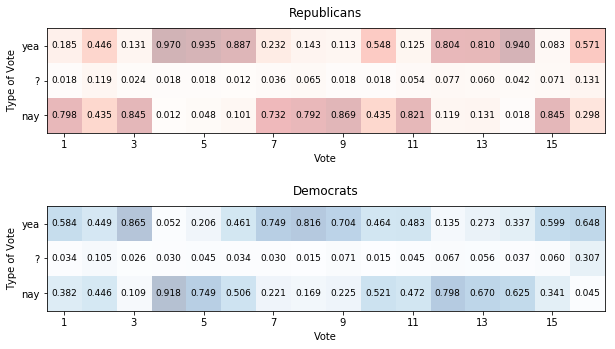

In [17]:
# Plotting Vote Summary
from libs.plot_utils import plot_summary
plot_summary(df)

### 2.2 - Principal Components Analysis
Here Principal Components Analysis is applied in order to project the data to a 2-dimensional space for visualization.  The first 4 components explain nearly 60% of the variance in the data, while the first component alone explains nearly 41% of the variance.  A scatter plot along the first two principal components shows a reasonable separation between the two classes.  Unfortunately, the classes are not linearly separable along this low-dimensional projection.

In [18]:
# Performing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=48)
X_pca = pca.fit_transform(X)

Explained variance from first 4 components: 0.595
Explained variance from first component: 0.408


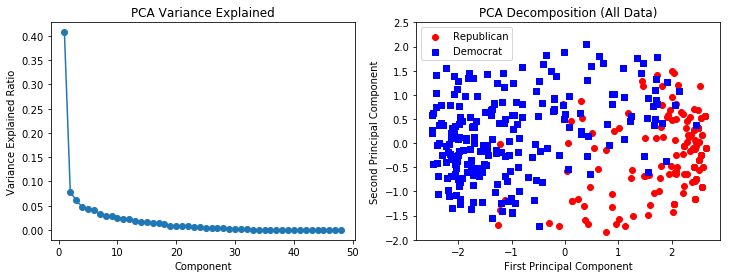

In [19]:
#Summarizing PCA Results
print('Explained variance from first 4 components: %.3f' 
      % pca.explained_variance_ratio_[:4].sum())
print('Explained variance from first component: %.3f' 
      % pca.explained_variance_ratio_[:1].sum())

# Plotting PCA Results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

# Plotting variance explained
evr = pca.explained_variance_ratio_
ax1.plot(np.arange(1,evr.shape[0]+1), evr, marker='o')
ax1.set_ylabel('Variance Explained Ratio')
ax1.set_xlabel('Component')
ax1.set_title('PCA Variance Explained')

# PCA Decomposition
ax2.scatter(X_pca[y==1,0], 
            X_pca[y==1,1],
            marker='o', c='red',
            label='Republican')
ax2.scatter(X_pca[y==0,0], 
            X_pca[y==0,1],
            marker='s', c='blue',
            label='Democrat')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_ylim([-2,2.5])
ax2.set_title('PCA Decomposition (All Data)')
ax2.legend(loc='upper left')

plt.show()

### 2.3 - Linear Discriminant Analysis (for Dimensionality Reduction)
Here Linear Disciminant Analysis (LDA) is applied to project the data along a single dimension that describes the separation between classes (the discriminant variable).  Since LDA makes the use of the target variable, only the training set data are included in this projection.  Similar to the PCA projection, the classes are not linearly separable in the 1-dimensional LDA projection.  The Republicans are more tightly clustered, with a few outliers, while the Democrats exhibit a pair of clusters, one of which overlaps strongly with the main Republican cluster.

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_train, y_train)

C:\Users\Mickey Vogt\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


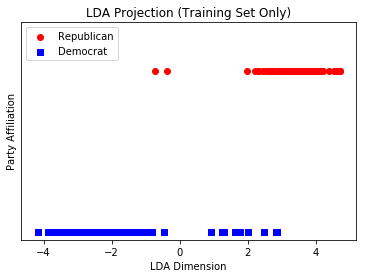

In [21]:
# Plotting along LDA dimension
plt.scatter(X_lda[y_train==1,0], 
            np.ones([X_lda[y_train==1].shape[0],1]),
            marker='o', c='red',
            label='Republican')
plt.scatter(X_lda[y_train==0,0], 
            np.zeros([X_lda[y_train==0].shape[0],1]),
            marker='s', c='blue',
            label='Democrat')
plt.xlabel('LDA Dimension')
plt.ylabel('Party Affiliation')
plt.tick_params(axis='y',left='off',labelleft='off')
plt.ylim([-0.05,1.3])
plt.title('LDA Projection (Training Set Only)')
plt.legend(loc='upper left')
plt.show()

## 3 - Benchmark Classifier ('Unregularized' Logistic Regression) <a id="sec3"></a>
---
To quickly benchmark the classification tast, an "unregularized" (extremely small regularization parameter) simple linear regression is applied to the data.  Using a decision boundary threshold of 0.5, a fit to the entire training set gives a training accuracy of 100% and a simple 5-fold cross validation accuracy of 95.1 $\pm$ 3.0%.  This suggests that some regularization is needed to improve generalization and prevent overfitting.  However, A 95% accuracy rate appears quite reasonable for this task, and this result provides a measure to see whether other algorithms can improve upon this performance.

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e6, random_state=33)
lr.fit(X_train, y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
# Estimating Test Accuracy via 5-fold Cross Validation
from sklearn.metrics import accuracy_score

# Training Accuracy
print('Training Accuracy: %.3f'
      % accuracy_score(y_true=y_train,
                       y_pred = lr.predict(X_train)))

# Cross Validation Estimation of Test Accuracy
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(estimator=lr,
                         X=X_train,
                         y=y_train,
                         cv=5)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores_lr),
        np.std(scores_lr)))

Training Accuracy: 1.000
CV Accuracy: 0.951 +/- 0.030


## 4 - Choosing an Algorithm using Nested Cross Validation <a id="sec4"></a>
---
Four different classification algorithms are applied and their results are compared.  For each algorithm, a grid search is applied over various hyperparameters described below.  Algorithm performance is compared using a 5x2 nested Cross Validation scheme.  The inner loop tunes the hyperparameters via 2-fold CV, while the outerloop performs 5-fold CV to estimate test accuracy for the chosen hyperparameters.

### 4.1 - Classification Algorithms (and Hyperparameters)
1. Logistic Regression
 * 'C' - regularization strength
 * 'penalty' - type of regularization ('l1' - Lasso, 'l2' - Ridge)
2. Support Vector Machines (SVM)
 * 'C' - Cost parameter
 * 'kernel' - linear SVM vs. using a Radial Basis Function (RBF) Kernel
 * 'gamma' - kernel coefficient (for RBF)
3. Random Forest
 * 'n_estimators' - the number of trees to include in ensemble
 * 'max_features' - the number of features to be randomly included for consideration for a particular tree
 * 'criterion' - measure for information gain and deciding decision tree split
4. K-Nearest Neighbors
 * 'n_neighbors' - the number of nearest neighbors to consider for classification
 * 'p' - exponent for Mikowski distance metric (p=1 for Manhattan distance, p=2 for Euclidean distance)
 
 
Note: A further discussion of the various properties and merits classification algorithms will be included later.

In [24]:
# Creating an Algorithm list w/ elements [model name, estimator, parameter grid]
grid_estimators = []

# Logistic Regression
from sklearn.linear_model import LogisticRegression
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'penalty': ['l1', 'l2']}]
grid_estimators.append(['Logistic Regression', LogisticRegression(), param_grid])

# Support Vector Machines
from sklearn.svm import SVC
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel': ['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
grid_estimators.append(['Support Vector Machines', SVC(), param_grid])

# Random Forest
from sklearn.ensemble import RandomForestClassifier
param_grid = [{'n_estimators': [10, 100, 1000],
               'max_features': [4, 7, 16, 24],
               'max_depth': [2, 4, 6, 8],
               'criterion': ['entropy']}]
grid_estimators.append(['Random Forest', RandomForestClassifier(), param_grid])

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'n_neighbors': [1, 3, 5, 10, 30],
               'p': [1, 2]}]
grid_estimators.append(['K Nearest Neighbors', KNeighborsClassifier(), param_grid])

### 4.2 - Nested Cross-Validation Results

In [25]:
# Performing 5x2 Nested CV for each algorithm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

for model in grid_estimators:
    gs = GridSearchCV(estimator=model[1],
                      param_grid=model[2],
                      scoring='accuracy',
                      cv=2)
    scores = cross_val_score(estimator=gs,
                                X=X_train,
                                y=y_train,
                                cv=5)
    print('Model: %s; CV Accuracy: %.3f +/- %.3f' 
          % (model[0], 
             np.mean(scores), 
             np.std(scores)))

Model: Logistic Regression; CV Accuracy: 0.963 +/- 0.037
Model: Support Vector Machines; CV Accuracy: 0.968 +/- 0.031
Model: Random Forest; CV Accuracy: 0.960 +/- 0.047
Model: K Nearest Neighbors; CV Accuracy: 0.925 +/- 0.042


Of the algorithms included in this comparison, Support Vector Machines appears to perform the best for this data set.  However, it's performance does not significantly improve on any of the other algorithms (within CV error).  In fact, all algorithms perform reasonably well, with the possible exception of the non-parametric K-Nearest Neighbors Algorithm.

## 5 - Tuning Hyperparameters and Evaluting Final Model <a id="sec5"></a>
---
Given that SVM performed the best on the 5x2 CV for model selection, this algorithm is chosen for the final model.  Again a grid search is performed with 5-fold CV in order to tune the hyperparameters of this model.  The best performing hyperparameters are then used to train the final model on the entire training set before evaluating the model on the test set.

### 5.1 - Grid Search Results

In [26]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range,
               'kernel': ['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs_svm = GridSearchCV(estimator=SVC(random_state=33),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5)
gs_svm.fit(X_train, y_train)
print('Grid Search Best CV Accuracy: %.3f +/- %.3f' 
      % (gs_svm.best_score_, 
         gs_svm.cv_results_['std_test_score'][gs_svm.best_index_]))
print('Grid Search Best Parameters: %s' % gs_svm.best_params_)

Grid Search Best CV Accuracy: 0.968 +/- 0.031
Grid Search Best Parameters: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}


The RBF kernel with a coefficient of 0.1 and a cost of 1.0 produces the best CV result over the grid search.  The resulting accuracy (96.8 $\pm$ 3.1%) is the same as produced from the nested CV search.  The final model is trained using these hyperparameters.

### 5.2 - Training the Final Model
Training the SVM model on the entire training set using the RBF Kernel (gamma = 0.1, C = 1.0) results in a 98% training set accuracy.  The PCA and LDA projections of the training data, as well as the resulting confusion matrix, are shown below.  The misclassified training examples include the two Republicans that overlap most strongly with the main Democrat cluster and five of the Democrats that stray farthest from their main party cluster according the LDA projection.

Train Accuracy: 0.980


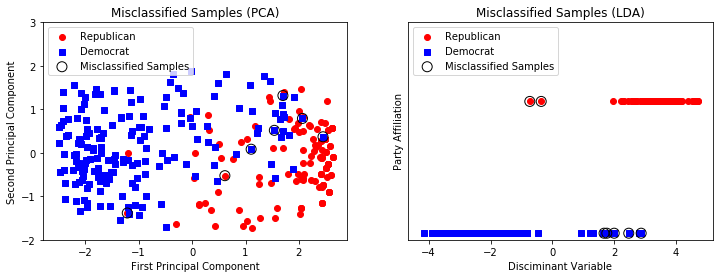

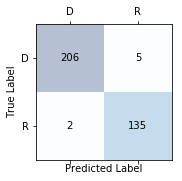

In [27]:
# Training the model
gs_svm.best_estimator_.fit(X_train, y_train)

# Test Accuracy Score
print('Train Accuracy: %.3f'
      % accuracy_score(y_true=y_train,
            y_pred=gs_svm.best_estimator_.predict(X_train)))

# Plotting Training Results
from libs.plot_utils import plot_class_results
plot_class_results(X = X_train, y = y_train,
                   estimator = gs_svm.best_estimator_,
                   X_pca = pca.transform(X_train),
                   X_lda = X_lda)

### 5.3 - Evaluating the Final Model
The Kernel SVM model has a **92% accuracy** when evaluated on the test set data.  Again, the PCA and LDA projections and confusion matrix with regards to the test data are shown below.  As with the training data, it misclassifies the outliers with respect to each party according the LDA projection.  However, it also misclassifies a pair or Republicans that are much closer to the main party cluster.  While a 92% test accuracy rate might be reasonable, as expected our CV results over estimated our test error.

Test Accuracy: 0.920


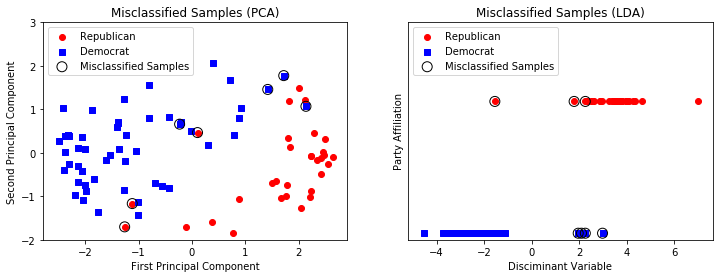

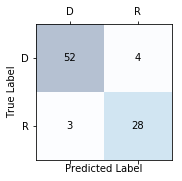

In [28]:
# Test Accuracy Score
print('Test Accuracy: %.3f'
      % accuracy_score(y_true=y_test,
            y_pred=gs_svm.best_estimator_.predict(X_test)))

# Plotting Test Results
plot_class_results(X = X_test, y = y_test,
                   estimator = gs_svm.best_estimator_,
                   X_pca = pca.transform(X_test),
                   X_lda = lda.transform(X_test))